In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import model_based_agent as mba 
import worm_env as we 
import worm_env_old as weo
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [9]:
def make_dist_dict2(df, sm_pars=None,
    prev_act_window=3,
    lp_frac=None):
    # This version doesn't smooth reward matrices. First subtracts them and then smooths the resulting matrix.
    # Stores difference in r_on and adds variances; sets r_off to 0's. 
    # Makes a dictionary of distributions using trajectory statistics.
    # sm_pars is a dict of form {'lambda': .05, 'iters': 30}
    #     If None, then no smoothing.
    # Lp_frac: [0,1]. Models find a number to subtract from light-on matrices, in order for
    #  this fraction of observations to remain above their corresponding light-off spots.

    traj_on = df.query('prev_actions=='+str(prev_act_window))
    traj_off = df.query('prev_actions==0')

    r_on, b_on, h_on, count_on = ut.make_stat_mats(traj_on)
    r_off, b_off, h_off, count_off = ut.make_stat_mats(traj_off)

    all_mats = [r_on,b_on,h_on,r_off,b_off,h_off]
    counts = [count_on,count_off]
    counts_lp = counts[0]+counts[1]

    for i in [1,2,4,5]:
        for j in range(2):
            if j==1:
                ang_par = False 
            else:
                ang_par = True
            all_mats[i][:,:,j] = ut.lin_interp_mat(all_mats[i][:,:,j], ang_par)
            
            if sm_pars is not None:
                all_mats[i][:,:,j] = ut.smoothen(all_mats[i][:,:,j], 
                                                counts[i//3], ang_par, 
                                                smooth_par=sm_pars['lambda'], iters=sm_pars['iters'])
                
    # Turns r_on and r_off matrices into their differences stored in r_on. (r_off is now set to 0)
    r_on[:,:,0] = r_on[:,:,0]-r_off[:,:,0]
    r_on[:,:,1] = r_on[:,:,1]+r_off[:,:,1]
    for i in range(2):
        r_on[:,:,i] = ut.lin_interp_mat(r_on[:,:,i], False)
    r_on[:,:,0] = ut.smoothen(r_on[:,:,0], counts_lp, False, smooth_par=sm_pars['lambda']*5, iters=sm_pars['iters'])
    r_off = np.zeros(r_off.shape)
    
    # This block is for light penalty implementation. Only applied to r_on.
    if lp_frac is None:
        light_penalty = 0
    else:
        r_diffs = r_on[:,:,0]-r_off[:,:,0]
        r_diffs_sorti = np.unravel_index(np.argsort(-r_diffs,axis=None), r_on[:,:,0].shape) # Subtract means and gets sorted indices.
        r_diffs_sorted = r_diffs[r_diffs_sorti]
        #counts_lp = np.ones((12,12)) ############
        count_lim = np.sum(counts_lp)*lp_frac
        cs = np.cumsum(counts_lp[r_diffs_sorti]) < count_lim
        cutoff_ind = [i for i,x in enumerate(cs) if not x][0]
        light_penalty = r_diffs_sorted[cutoff_ind]
        print(f'Penalty {light_penalty}')

    dist_dict = {
        'body_on': b_on,
        'body_off': b_off,
        'head_on': h_on,
        'head_off': h_off,
        'reward_on': r_on - light_penalty,
        'reward_off': r_off,
    }    
    return dist_dict

In [43]:
folders = ['./Data/HTFix19-01-18-47/',
           './Data/HTFix19-01-20-29/',
           './Data/HTFix19-01-21-18/',
           './Data/HTFix20-01-09-04/',
           './Data/HTFix20-01-09-42/',
           './Data/HTFix20-01-10-41/',
          ]

dh = mba.DataHandler()
dh.load_df(folders[0]+'alls.pkl')
for f in folders[1:]:
    dh.add_df_to_df([f+'alls.pkl'])

In [44]:
dh.df

,t,obs_b,angs,prev_actions,reward,loc,target,obs_h,next_obs_b,next_obs_h
0,0.984,-30,"[90, 270]",3,6.421441,"[1007.8554216867469, 1002.0602409638554]",90,30.0,-30.0,30.0
1,1.172,-30,"[90, 270]",2,6.134315,"[1008.2528735632184, 1000.9195402298851]",90,30.0,-30.0,30.0
2,1.375,-30,"[90, 270]",1,6.425035,"[1008.3827160493827, 1000.469135802469]",90,30.0,-30.0,30.0
3,1.562,-30,"[90, 240]",0,6.587415,"[1008.6585365853659, 999.7317073170732]",90,30.0,-30.0,30.0
4,1.765,-30,"[90, 240]",0,6.356707,"[1008.6470588235295, 999.3764705882354]",90,30.0,-30.0,60.0
...,...,...,...,...,...,...,...,...,...,...
47319,235.000,30,"[240, 120]",0,0.400000,"[101.6, 845.2]",180,30.0,120.0,-90.0
47320,297.797,120,"[210, 90]",2,0.666667,"[89.0, 888.0]",180,-90.0,120.0,-30.0
47321,297.984,120,"[270, 90]",3,0.666667,"[88.57142857142857, 886.2857142857143]",180,-30.0,120.0,-30.0
47322,298.156,120,"[270, 90]",2,0.071429,"[88.42857142857143, 887.2857142857143]",180,-30.0,120.0,-30.0


In [45]:
mod = make_dist_dict2(dh.df,sm_pars={'lambda':.1,'iters':10},prev_act_window=3,lp_frac=.45)

Penalty 0.15468397485578136


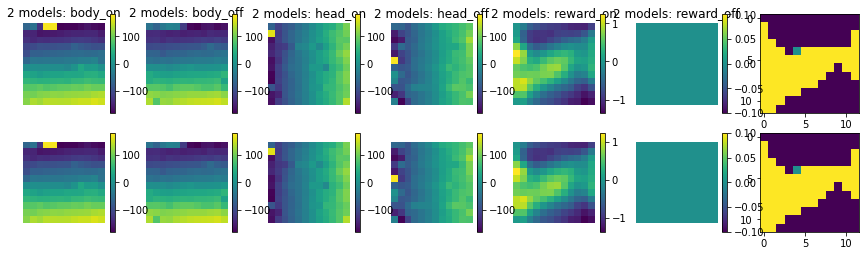

In [28]:
mods_plt = [mod,mod]
plot_mods(mods_plt)

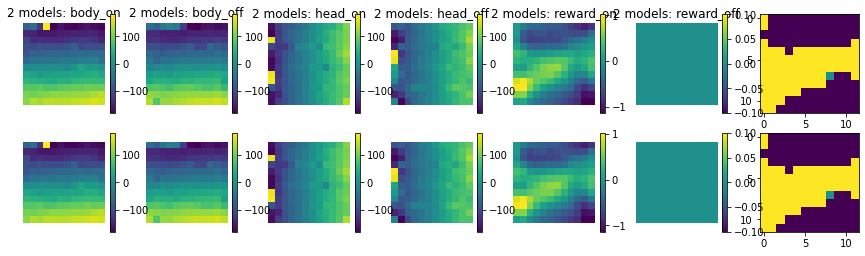

In [42]:
mods_plt = [mod,mod]
plot_mods(mods_plt)

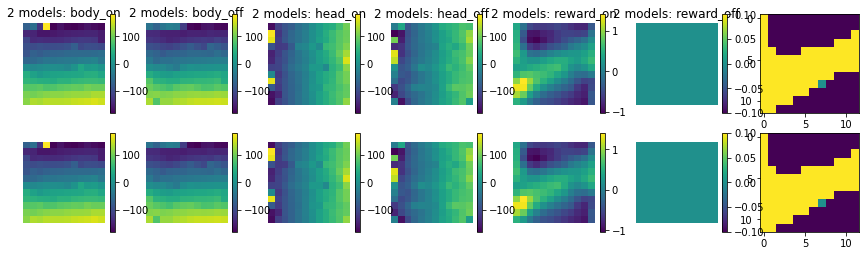

In [46]:
mods_plt = [mod,mod]
plot_mods(mods_plt)

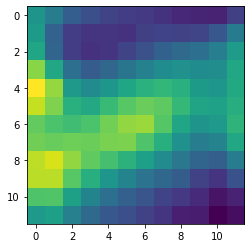

In [29]:
plt.imshow(mod['reward_on'][:,:,0])

# Evaluating smoothed policy on animal

In [2]:
detpol = np.zeros((12,12))+1
detpol[:6,:6] = -1
detpol[6:,6:] = -1

def pol_test(mod,folder,sets,
            rand_ep_time = 120,
            eval_ep_time = 120,
            worm_ep_len = 120):
    # Takes a model with reward_on as the policy (>0 light on; <0 light off) and 
    # reward_off as zeros. Runs a random episode followed by an evaluation episode {sets} times.
    # Saves every episode trajectory as rand{i}.pkl or eval{i}.pkl (dicts).
    # Returns rands (list) and evals (list) of reward vectors.
    
    if os.path.isdir(folder):
        raise ValueError('Folder already exists.')
    os.mkdir(folder)
    
    rands,evals = [],[]
    worm = weo.ProcessedWorm(0,ep_len=worm_ep_len)
    cam,task = init_instruments()
    
    # Random policy
    cp = mod['reward_on'][:,:,0].copy().flatten() #detpol.copy().flatten()
    np.random.shuffle(cp)
    ant_rand = tab.Q_Alpha_Agent() 
    ant_rand.Qtab = np.zeros(ant_rand.Qtab.shape)
    ant_rand.Qtab[:,1] = cp
    runner_rand = mba.WormRunner(ant_rand, worm, act_spacing=1)
    
    # Test policy
    ant_test = tab.Q_Alpha_Agent() # Test policy
    ant_test.Qtab = np.zeros(ant_test.Qtab.shape)
    ant_test.Qtab[:,1] = mod['reward_on'][:,:,0].flatten() #detpol.flatten()
    runner_test = mba.WormRunner(ant_test, worm, act_spacing=1)
    
    
    for s in range(sets):
        fname_r = folder+f'rand{s}.pkl'
        fname_e = folder+f'eval{s}.pkl'
        print(f'Running set {s}')
        
        evals.append(runner_test.eval_ep(cam,task,fname_e,eval_eps=eval_ep_time//worm_ep_len))
        task.write(0)
        rands.append(runner_rand.eval_ep(cam,task,fname_r,eval_eps=rand_ep_time//worm_ep_len))
        task.write(0)
    
    cam.exit()
    task.write(0)
    task.close()
    
    return rands,evals,ant_rand,ant_test

def get_model_from_files(files,lp_frac):
    dh = mba.DataHandler()
    dh.load_df(files[0]+'alls.pkl')
    for f in files[1:]:
        dh.add_df_to_df([f+'alls.pkl'])
    mset = eme.ModelSet(1,frac=1,lp_frac=lp_frac)
    mset.make_models(dh,sm_pars={'lambda':.1,'iters':10})
    return mset.models[0]

def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on'][:,:,0]-mod['reward_off'][:,:,0]),vmin=-1,vmax=1)

In [8]:
folder = './Data/HTTest'+datetime.now().strftime('%d-%m-%H-%M')+'/'
files = ['./Data/HTFix19-01-18-47/',
           './Data/HTFix19-01-20-29/',
           './Data/HTFix19-01-21-18/',
           './Data/HTFix20-01-09-04/',
           './Data/HTFix20-01-09-42/',
           './Data/HTFix20-01-10-41/',
          ]

mod = get_model_from_files(files,.4)

On model 0
Penalty 0.17816879028072646


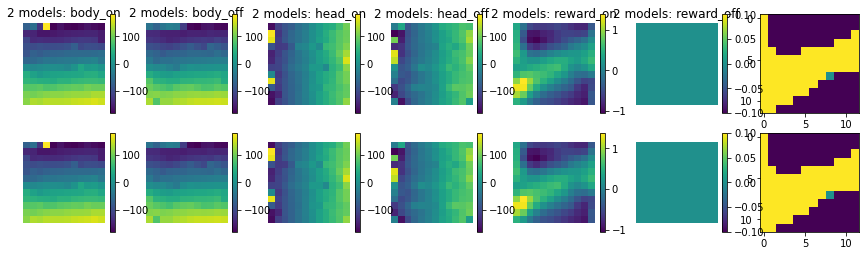

In [4]:
plot_mods([mod,mod])

In [9]:
rands,evals,ant_rand,ant_test = pol_test(mod,folder,1,            
            rand_ep_time = 120,
            eval_ep_time = 120,
            worm_ep_len = 120)

Running set 0


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\RLWorms\01_13_reals\improc.py:196: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


# Two test runs with deterministic policy and random policy (shuffled det)

In [6]:
[print(np.mean(rands[i])) for i in range(1)]
[print(np.mean(evals[i])) for i in range(1)]

-0.3485151440531889
0.19443009201073713


[None]

In [11]:
[print(np.mean(rands[i])) for i in range(1)]
[print(np.mean(evals[i])) for i in range(1)]

-0.4307155171583498
0.6852167238967668


[None]

# Runs with found policy and random policy (shuffled found)

In [5]:
# HTTest20-01-17-08
[print(np.mean(rands[i])) for i in range(1)]
[print(np.mean(evals[i])) for i in range(1)]

0.16994080798075242
-0.3035586081156972


[None]

In [8]:
# HTTest20-01-17-14
[print(np.mean(rands[i])) for i in range(1)]
[print(np.mean(evals[i])) for i in range(1)]

0.06279451788491452
0.5847019313506728


[None]

In [5]:
# HTTest20-01-17-20
[print(np.mean(rands[i])) for i in range(1)]
[print(np.mean(evals[i])) for i in range(1)]

0.12297582812403397
0.49921642185884474


[None]

In [10]:
# HTTest20-01-17-27
[print(np.mean(rands[i])) for i in range(1)]
[print(np.mean(evals[i])) for i in range(1)]

-0.3152529498151617
0.10234044608060362


[None]

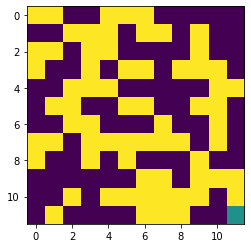

In [11]:
plt.imshow(np.sign(ant_rand.Qtab[:,1].reshape(12,12)))

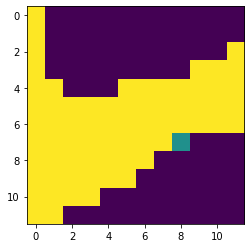

In [12]:
plt.imshow(np.sign(ant_test.Qtab[:,1].reshape(12,12)))